# **Calculation of SNR for extreme values of beta position of a fixed source**

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import healpy
import h5py
import os 

# Conditions

In [26]:
G=6.6740e-11
c=299792458.0
dObs=8e-3 #en Mpc
mass_BH=10**6
rg=1.48e9
chi=0.5

In [21]:
def get_peak(a, lgw=2, **kwargs): 
    cloud = gwaxion.BosonCloud.from_parameters(1, 1, 0, alpha=a, evolve_params={'y_0': 1E-8}, **kwargs) 
    return cloud.gw(lgw).h0r, cloud.gw(lgw).f

In [23]:
import gwaxion
import multiprocessing
from functools import partial

alphas = np.arange(0.01, 0.25, 0.001)

distance = dObs

bh = gwaxion.BlackHole(mass=mass_BH, chi=chi, msun=True)
# collect peak values
pool = multiprocessing.Pool(8)
h0r_fs = pool.map(partial(get_peak, m_bh=bh.mass_msun, chi_bh=bh.chi), alphas)
h0rs_num, fgws_num = np.array(h0r_fs).T
        
# h0rs are the amplitudes 1m away from the source, so rescale by actual distance
h0s_num = h0rs_num / distance
    
best = max(zip(h0s_num, alphas))
alpha_best=best[1]
print(alpha_best)

0.11699999999999991


# Superrad

In [28]:
m_boson=(alpha_best*6.62607e-34*c)/(2*np.pi*rg)*(1/1.6e-19)
from superrad import ultralight_boson as ub
bc= ub.UltralightBoson(spin=0, model="non-relativistic")
wf = bc.make_waveform(mass_BH, chi, m_boson, units="physical",evo_type="matched")

In [29]:
orbit_file_name='/local/home/dd274198/Documents/lisaenv/keplerian-orbits-1-0-2.h5'
with h5py.File(orbit_file_name, 'r') as fi:
    orbit_t0 = fi.attrs['t0']
    duration=fi.attrs['tduration']
    #print(fi.attrs.keys())
    print(duration)
    


31536000.0


In [30]:
Tobs=3.0e7
dt=25
N=int(Tobs/dt)
t = orbit_t0 + np.arange(0,1.2*Tobs,dt)
N_pad=len(t)-N
print(len(t))   
print(N) 
print(N*dt)
print(N_pad)

1440000
1200000
30000000
240000


In [31]:
sec_hour = 3600.0
sec_day=sec_hour*24
sec_year=sec_day*365
t_freq = np.arange(0,10**9*sec_year,10**2*sec_year)
print(len(t))
print(len(t_freq))


1440000
10000000


In [32]:
from lisagwresponse import ReadStrain
LINKS = [12, 23, 31, 13, 32, 21]
import pytdi
import pytdi.michelson
from pytdi.michelson import X2, Y2, Z2
from pytdi import Data

gw_beta=[0,np.pi/2]
value=len(gw_beta)
response=[]
X2gw = []
for i in range(value):
    response.append([])
    X2gw.append([])

strain_file='gwresponse_file_pos2305.h5'
    
    
for i in range(value):
    thetaObs = np.pi/4 #Observing angle w.r.t. spin axis
    phi=wf.phase_gw(t)
    hp,hx,delta = wf.strain_amp(t_freq,thetaObs,dObs)
    hp0_f,hx0_f,delta=wf.strain_amp(t,thetaObs,dObs)
    hp_f,hx_f=hp0_f*np.cos(phi),hx0_f*np.sin(phi)
    #fgw = wf.freq_gw(t_freq)
    
    if os.path.exists(strain_file):
            os.remove(strain_file)
    rs=ReadStrain(t,hp_f,hx_f,strain_interp_order=5,orbits=orbit_file_name, 
    orbit_interp_order=2, dt=dt, size=N,gw_beta=gw_beta[i], gw_lambda=0,t0=orbit_t0+10)
    response[i]=rs.compute_gw_response(rs.t,LINKS)
    rs.write(path=strain_file)
    data = Data.from_gws(strain_file, orbit_file_name)
    built_gw_X2 = X2.build(**data.args)
    X2gw[i] = built_gw_X2(data.measurements)
    





    

In [33]:
#fonction Périodogramme

In [34]:
def Pd_num(x,dt):
    #window=np.blackman(len(x))
    window=1
    #N_w=np.sum(window**2)
    N_w=len(x)
    return dt*(2/N_w)*(np.abs(np.fft.rfft(window*x)))**2

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import ldc
from ldc.lisa.noise import get_noise_model
from ldc.lisa.noise import NumericNoise
AddLDC = True

f= np.fft.rfftfreq(N,d=dt)


PSD_sciRD_X2usb = []
for i in range(value):
    PSD_sciRD_X2usb.append([])
    
Pd_X2n = []
for i in range(value):
    Pd_X2n.append([])
    
#Pd_A2n = []
#Pd_E2n = []
#Pd_T2n = []
#for i in range(value):
#   Pd_A2n.append([])
#   Pd_E2n.append([])
#   Pd_T2n.append([])
    
    
for i in range(value):
    ## Noise level in the Science Requirement Document
    PSD_sciRD_X2usb[i] = get_noise_model("SciRDv1",f[1:]).psd(option='X',tdi2=True)
    #PSD_sciRD_A2[i] = get_noise_model("SciRDv1",f0).psd(option='A',tdi2=True)
    #PSD_sciRD_E2[i] = get_noise_model("SciRDv1",f0).psd(option='E',tdi2=True)
    #PSD_sciRD_T2[i] = get_noise_model("SciRDv1", f0).psd(option='T',tdi2=True)
    
    ## Noise response level 
    Pd_X2n[i]=Pd_num(X2gw[i],dt)

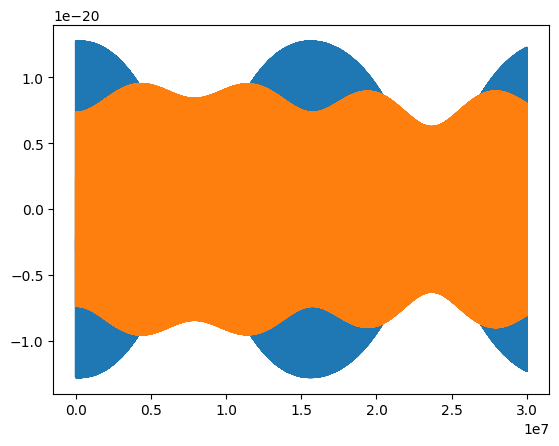

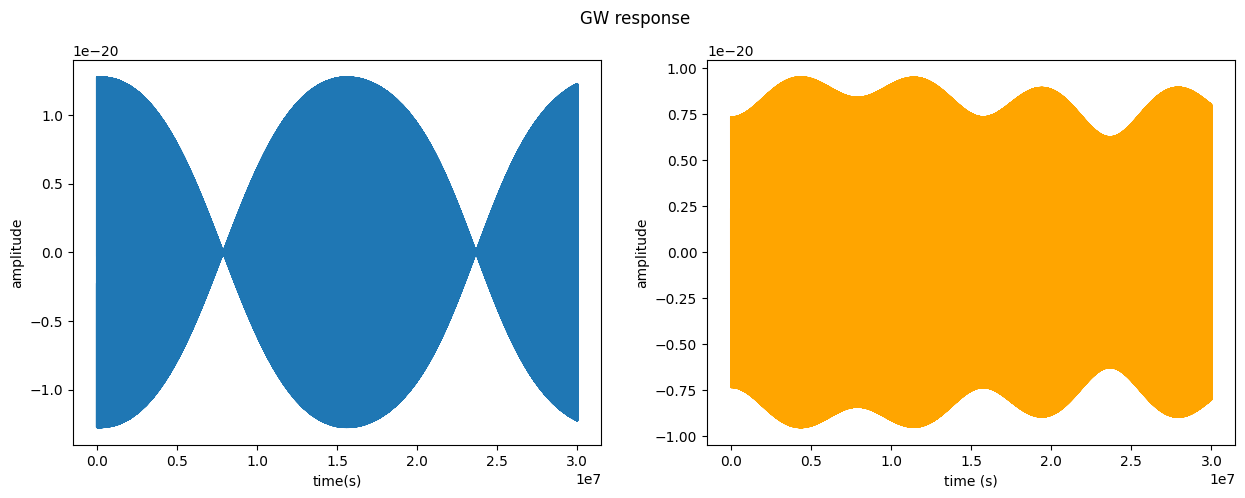

In [70]:
tp = orbit_t0 + np.arange(0,Tobs,dt)


for i in range(value):
    #plt.figure(figsize=(15,10))
    plt.plot(tp[:], X2gw[i])
    


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))


fig.suptitle('GW response')
ax1.plot(tp[:], X2gw[0])
ax2.plot(tp[:], X2gw[1],c='orange')
ax1.set_xlabel('time(s)')
ax1.set_ylabel('amplitude')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.savefig('GWres_pos.png')
plt.show()  


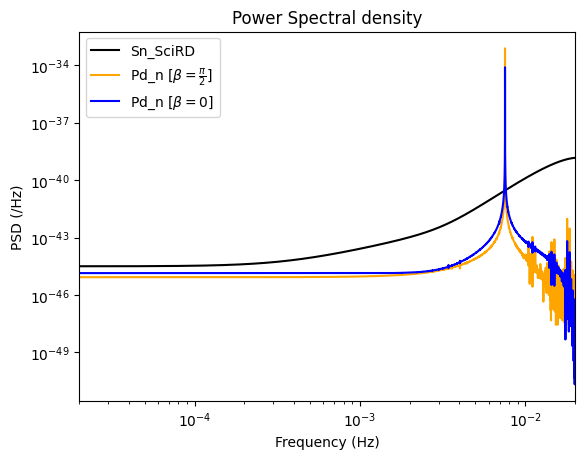

In [73]:

plt.figure()
plt.loglog(f[1:],PSD_sciRD_X2usb[i][:], label='Sn_SciRD',c='black')

      
plt.loglog(f[1:],Pd_X2n[1][1:],label=r'Pd_n [$\beta = \frac{\pi}{2}$]', c='orange')
plt.loglog(f[1:],Pd_X2n[0][1:],label=r'Pd_n [$\beta = 0]$',c='blue') 
        
plt.legend()
plt.xlim([2e-5,2e-2])
plt.title('Power Spectral density')
plt.ylabel('PSD (/Hz)')
plt.xlabel('Frequency (Hz)')
plt.savefig('PSDpos.png')


In [36]:
#SNR

In [43]:
SNRc_X2 = []
SNR_X2 = []

#SNRc_A2 = []
#SNRc_E2 = []
#SNRc_A2 = []
#SNR_tot=[]
#for i in range(value):
#    SNRc_A2.append([])
#    SNRc_E2.append([])
#    SNRc_T2.append([])
#   SNRc_tot.append([])
    
def SNR_carre(P_d,Sn_f):
    
    return 4*np.real(np.sum((P_d/(Sn_f))))*(1/Tobs)

for i in range(value):
    SNRc_X2.append((SNR_carre((dt*np.abs(np.fft.rfft(X2gw[i]))[1:])**2,PSD_sciRD_X2usb[i][:])))
    SNR_X2.append(np.sqrt(SNR_carre((dt*np.abs(np.fft.rfft(X2gw[i]))[1:])**2,PSD_sciRD_X2usb[i][:])))


print('Extreme SNR² values : ')
print('SNR² for gw_beta = O :',SNRc_X2[0])
print('SNR² for gw_beta = np.pi/2 :',SNRc_X2[1])
print('Extreme SNR values : ')
print('SNR for gw_beta = O :',SNR_X2[0])
print('SNR for gw_beta = np.pi/2 :',SNR_X2[1])

Extreme SNR² values : 
SNR² for gw_beta = O : 89506899.50805315
SNR² for gw_beta = np.pi/2 : 73259802.86404209
Extreme SNR values : 
SNR for gw_beta = O : 9460.808607516228
SNR for gw_beta = np.pi/2 : 8559.194054584934


In [39]:
import gwaxion

## Armlength in seconds
c = 299792458.0
L_m = 2.5e9
L = L_m/c
distance = 8e3 * gwaxion.PC_SI

bhb = gwaxion.BlackHoleBoson.from_parameters(m_bh=10**6, alpha=alpha_best, chi_bh=0.5)
bh = gwaxion.BlackHole(mass=10**6, chi=0.5, msun=True)
cloud = bhb.best_cloud()
fgw=cloud.fgw
h0 = bh.h0r_fit(fgw)/distance
print('GW frequency=',fgw)
print('h0= : ',h0)
omegaL = 2*np.pi*fgw*L
PSD_fX2 = get_noise_model("SciRDv1",fgw).psd(option='X',tdi2=True)
S_theoX2=(20/3)*(1+0.6*(omegaL)**2)*(PSD_fX2/((4*omegaL)**2*(np.sin(omegaL)**2)*(2*np.sin(2*omegaL))**2))


def SNRc_theo(h0,Tobs,Sh_theo):
    return 5*((2/5*h0)**2*Tobs/Sh_theo)

print('SNRc_theo =',SNRc_theo(h0,Tobs,S_theoX2))
print('SNR_theo =',np.sqrt(SNRc_theo(h0,Tobs,S_theoX2)))

GW frequency= 0.0075461071716961415
h0= :  2.764390305313834e-20
SNRc_theo = 66060362.87343744
SNR_theo = 8127.752633627419
